## Анализ оттока клиентов банка

Цель работы - провести анализ клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

[1. Предобработка данных](#1)
- выявление и обработка дубликатов и пропущенных значений
- выявление и обработка аномальных значений

[2. Исследовательский анализ данных](#2)

Посмотреть на данные в разрезах:
- «паспорта» клиентов (пол, возраст, город)
- доход и баланс клиентов
- пользование продуктами банка (кредитная карта, количество продуктов, активные клиенты)

[3.	Выделение портретов клиентов, которые склонны уходить из банка](#3)

Сегментация клиентов по данным оттока, различия в данных для ушедших и оставшихся клиентов:
- по полу, возрасту, городу
- по доходу и балансу 
- по пользованию продуктами банка

[4.	Проверка статистических гипотез](#4)

- гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним
- гипотеза различия дохода между ушедшими и оставшимися клиентами

[5. Машинное обучение](#5)
- отток клиентов: сравнение работы моделей
- кластеризация клиентов

[6.	Выводы](#6)

[7.	Работа с документацией](#7)

In [1]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
from scipy import stats as st
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# кластеризация
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

##  1. Предобработка данных <a name="1"></a>

- выявление и обработка дубликатов и пропущенных значений
- выявление и обработка аномальных значений

In [3]:
df = pd.read_csv('./bank_dataset.csv')
df.head()

,userid,score,City,Gender,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary,Churn
0,15677338,619,Ярославль,Ж,42,2,nan,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,nan,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userid           10000 non-null  int64  
 1   score            10000 non-null  int64  
 2   City             10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Objects          10000 non-null  int64  
 6   Balance          6383 non-null   float64
 7   NumOfProducts    10000 non-null  int64  
 8   CreditCard       10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Churn            10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.duplicated().sum()

0

- `userid` — id пользователя
- `score` — баллы кредитного скоринга
- `City` — город
- `Gender` — пол
- `Age` — возраст
- `Objects` — количество объектов в собственности
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов, которыми пользуется клиент
- `CreditCard` — есть ли кредитная карта
- `IsActiveMember` — активный клиент
- `EstimatedSalary` — оценочная заработная плата клиента
- `Churn` — ушёл/не ушёл клиент

Названия колонок соответствуют данным, типы данных переделывать не нужно, дубликатов нет.
Есть пропущенные значения в колонке `Balance` - посмотрим, сколько их, и есть ли при этом нулевые значения.

In [6]:
df['Balance'].isna().sum()

3617

In [7]:
len(df[df['Balance'] ==0])

0

Интересно, что пропущенных значений в поле `Balance` больше трети, а нулевых нет. Можно предположить, что это как раз отсутствие баланса - например, клиент пользуется банком для каких-то сторонних услуг и не держит там деньги. Можно заполнить пропущенные значения нулями, но это всегда успеется. 
Посмотрим на распределения значений в других колонках.

In [8]:
# проверяем, действительно ли все колонки, где может быть только два возможных значения, имеют их два
binary_columns = ['Gender', 'CreditCard', 'IsActiveMember', 'Churn']
for i in binary_columns:
    if df[i].nunique()>2:
        print (i)

In [9]:
# проверяем распределения для колонок, где может быть несколько возможных значений
varied_columns = ['NumOfProducts', 'Objects', 'City']
for i in varied_columns:
    print (df[i].value_counts(normalize = True))

1   0.51
2   0.46
3   0.03
4   0.01
Name: NumOfProducts, dtype: float64
2    0.10
1    0.10
7    0.10
8    0.10
5    0.10
3    0.10
4    0.10
9    0.10
6    0.10
10   0.05
0    0.04
Name: Objects, dtype: float64
Ярославль        0.50
Ростов Великий   0.25
Рыбинск          0.25
Name: City, dtype: float64


C:\Users\UX306\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\UX306\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\UX306\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
C:\Users\UX306\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


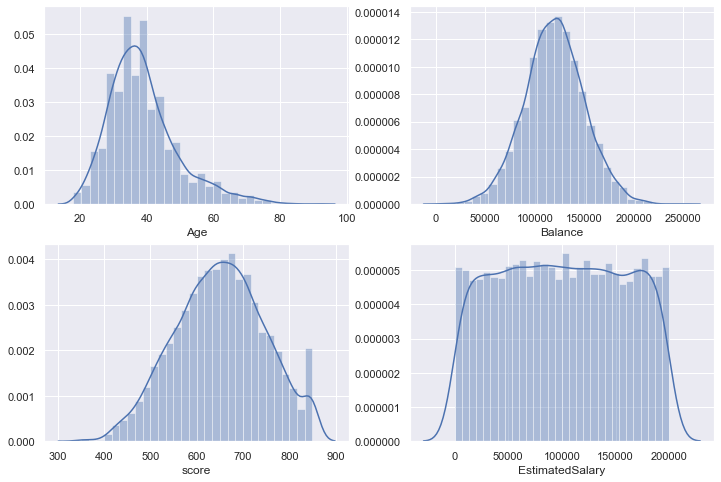

In [10]:
# проверяем распределения для колонок с разбросом значений
number_columns = ['Age', 'Balance', 'score', 'EstimatedSalary']

f, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, number_columns):
    sns.distplot(df[col], bins=30,ax=ax)
    ax.set(xlabel=col)
plt.show()

In [11]:
df[number_columns].median()

Age                   37.00
Balance           119839.69
score                652.00
EstimatedSalary   100193.91
dtype: float64

- в колонках, в которых должно быть два значения, их всего два;
- колонки с городами, используемыми продуктами и количеством объектов в собственности тоже выглядят адекватно;
- распределение возраста и баланса более-менее понятно;
- мы не знаем, откуда берется кредитный скоринг `score`, и будем принимать эти данные как есть;
- распределение оценочной зарплаты `EstimatedSalary` крайне странное - тут можно было бы ожидать распределение ближе к нормальному, но нет. 

##  2. Исследовательский анализ данных <a name="2"></a>

Посмотреть на данные в разрезах:
- [«паспорта» клиентов (пол, возраст, город)](#2.1)
- [доход и баланс клиентов](#2.2)
- [пользование продуктами банка (кредитная карта, количество продуктов, активные клиенты)](#2.3)

### "Паспорта" клиентов  <a name="2.1"></a>

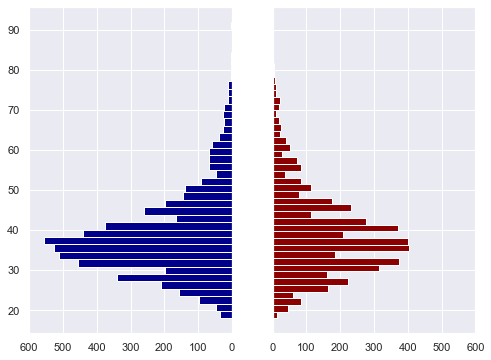

In [12]:
# распределение возраста в зависимости от пола
fig, axes = plt.subplots(ncols=2, sharey=True, figsize = (8,6))
axes[0].hist(df[df['Gender'] == 'М']['Age'], orientation="horizontal", bins = 40, color='darkblue')
axes[1].hist(df[df['Gender'] == 'Ж']['Age'], orientation="horizontal", bins = 40, color='darkred')
axes[0].set_xlim(0, 600)
axes[1].set_xlim(0, 600)
axes[0].invert_xaxis()
plt.show()

In [13]:
df['Gender'].value_counts(normalize = True)

М   0.55
Ж   0.45
Name: Gender, dtype: float64

В целом видно, что мужчин трудоспособного возраста и мужчин вообще больше, чем женщин.

In [14]:
# медианы для возраста, баланса, оценочной зарплаты
# и кредитного скоринга в разных городах
city_pivot = df.pivot_table(index = 'City', values = number_columns, 
                            aggfunc = 'median')
city_pivot

,Age,Balance,EstimatedSalary,score
City,,,,
Ростов Великий,38,119703.10,102397.22,651
Рыбинск,37,119726.45,99984.86,651
Ярославль,37,120135.15,99132.31,653


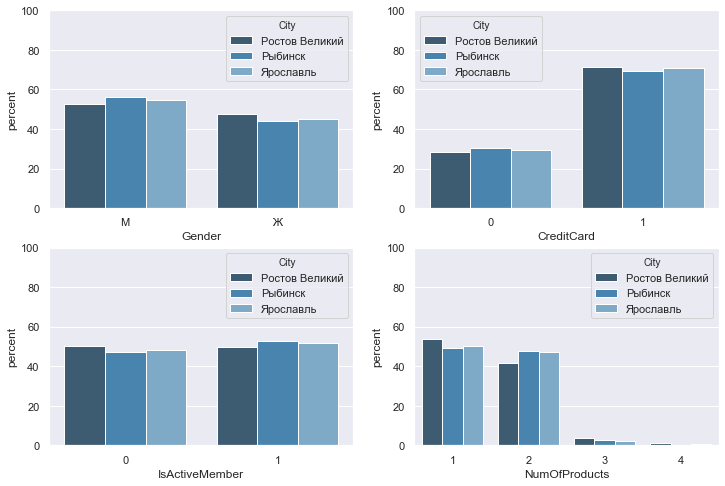

In [15]:
difference = ['Gender', 'CreditCard', 'IsActiveMember', 'NumOfProducts']

f, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, difference):
    percent = (df.groupby('City')[col]
                     .value_counts(normalize=True).mul(100)
                     .rename('percent').reset_index())
    sns.catplot(x=col, y='percent', hue='City',kind='bar',
              data=percent, palette="Blues_d", ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

Нельзя сказать, что есть значимая разница между городами - примерно одинаковые медианы зарплаты, баланса, кредитного скоринга и возраста для всех трех городов (незначительно выше зарплата в Ростове Великом). То же самое для других распределений - единственное отличие в том, что в Ростове больше процент клиентов с одним видом услуги, чем в других городах. Это может влиять на отток клиентов.

### Доход и баланс клиентов  <a name="2.2"></a>

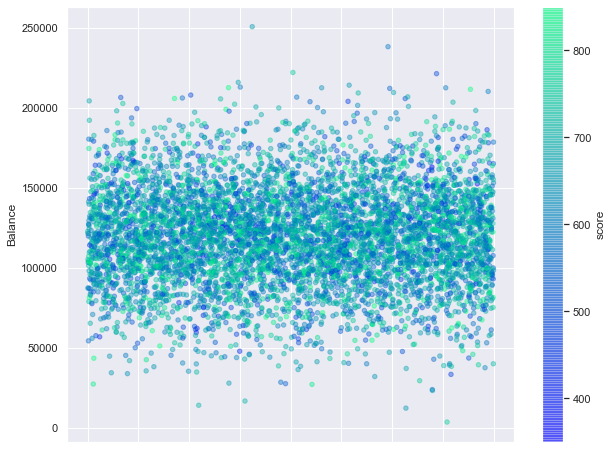

In [16]:
df.plot(x='EstimatedSalary', y='Balance', kind='scatter', 
          c = 'score', colormap='winter', grid = True, alpha=0.4, figsize = (10,8))

Ну, это примерно ни о чем не говорит. Мы видим пересечение распределения баланса `Balance` , которое похоже на нормальное, и распределения оценочной зарплаты `Estimated Salary`, которое более-менее равномерное, и видно, что кредитный скоринг `score` не зависит ни от того, ни от другого, и зарплата и баланс не связаны тоже никак. Вообще после такого много вопросов к данным.

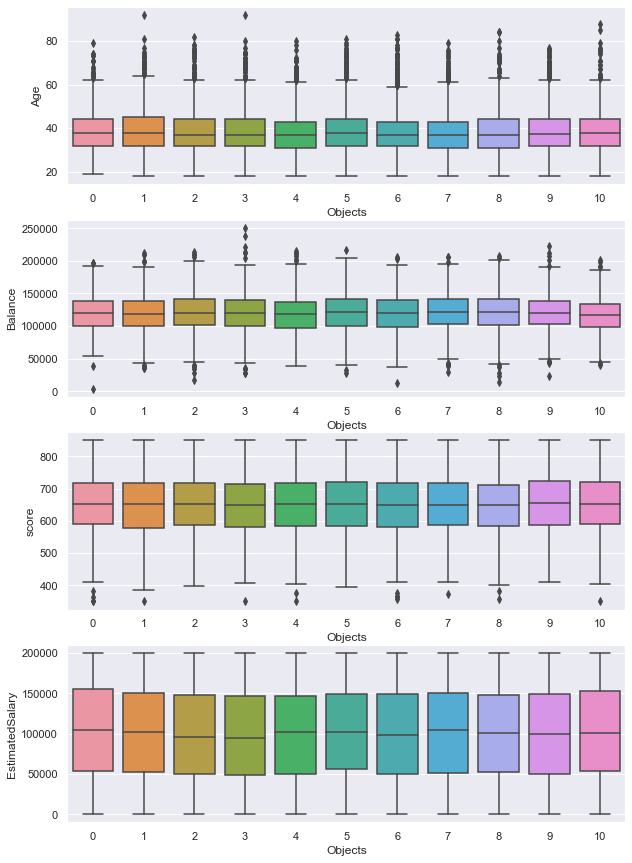

In [17]:
f, axes = plt.subplots(4, 1, figsize=(10, 15))
for ax, col in zip(axes.flat, number_columns):
    sns.boxplot(x = 'Objects', y = col, data=df,ax=ax)
plt.show()

Связи с объектами в собственности `Objects` тоже не видно - ни для кредитного скоринга, ни для оценочной зарплаты, ни для возраста. 
Я проверяла еще корреляции дохода, зарплаты и скоринга в разных вариантах, и корреляций нет.

### Пользование продуктами банка  <a name="2.3"></a>

In [18]:
# средние для колонок с двумя значениями
df[binary_columns].mean()

CreditCard       0.71
IsActiveMember   0.52
Churn            0.20
dtype: float64

In [19]:
# различаются ли средние показатели для параметра "активный клиент"
df.groupby('IsActiveMember').mean()

,userid,score,Age,Objects,Balance,NumOfProducts,CreditCard,EstimatedSalary,Churn
IsActiveMember,,,,,,,,,
0,15733553.13,647.97,38.00,5.10,120458.81,1.52,0.71,100767.20,0.27
1,15733792.77,652.93,39.79,4.93,119229.50,1.54,0.70,99452.97,0.14


In [20]:
# различаются ли средние показатели для тех, у кого есть кредитная карта, и тех, у кого нет
df.groupby('CreditCard').mean()

,userid,score,Age,Objects,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Churn
CreditCard,,,,,,,,,
0,15735238.06,651.35,39.11,4.91,119519.12,1.53,0.52,100974.40,0.21
1,15733024.75,650.19,38.84,5.05,119960.16,1.53,0.51,99721.16,0.20


Никакой существенной разницы для тех, у кого есть кредитная карта `CreditCard`, и тех, у кого ее нет, не обнаруживается;
то же для параметра "активный клиент" `IsActiveMember`, за исключением того, что шансы для неактивного клиента уйти из банка окончательно (`Churn`) все-таки выше.

In [21]:
df.groupby('NumOfProducts').mean()

,userid,score,Age,Objects,Balance,CreditCard,IsActiveMember,EstimatedSalary,Churn
NumOfProducts,,,,,,,,,
1,15732367.90,649.12,39.67,4.97,119894.16,0.70,0.50,99487.26,0.28
2,15734841.49,652.19,37.75,5.05,119660.94,0.71,0.53,100452.01,0.08
3,15741816.49,648.11,43.20,5.00,119475.69,0.71,0.42,104318.13,0.83
4,15719361.27,653.58,45.68,5.30,122260.61,0.68,0.48,104763.72,1.00


Показатели баланса `Balance`, количества объектов в собственности `Objects`, наличия кредитки `CreditCard`, показатель оценочной зарплаты `Estimated Salary` и кредитного скоринга `score` различаются для пользователей разного количества продуктов незначительно; они сдвигаются для случаев 3 и 4 продуктов, но это может объясняться их малым количеством (данных так мало, что распределение не успевает выровняться). 

Для возраста смещение в большую сторону для пользователей 3 и 4 продуктов все же видно.

Значительно меняется отток `Churn` для пользователей разного количества продуктов.

В заключение исследовательского анализа данных построим матрицу корреляций.

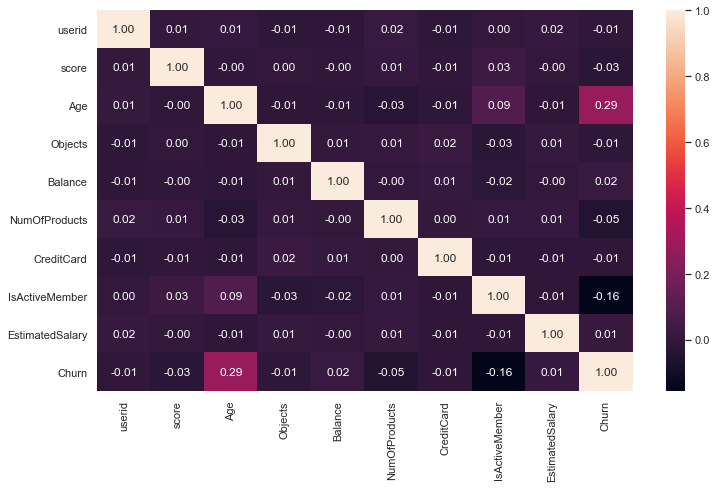

In [22]:
corr = df.corr()
f, ax = plt.subplots(figsize = (12,7))
ax = sns.heatmap(corr, xticklabels = corr.columns, fmt='.2f', 
                 yticklabels = corr.columns, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Ну, так не может быть просто - чтобы баланс вообще не был связан с доходом, с возрастом, активностью клиентов или вероятностью оттока. Отметим для себя корреляцию оттока и возраста, которую рассмотрим дальше, но вообще - еще раз убеждаемся в том, что данные не настоящие.

##  3. Выделение портретов клиентов, которые склонны уходить из банка <a name="3"></a>

Сегментация клиентов по данным оттока, различия в данных для ушедших и оставшихся клиентов:
- по полу, возрасту, городу
- по доходу и балансу 
- по пользованию продуктами банка

In [23]:
difference = ['Gender', 'CreditCard', 'IsActiveMember', 'NumOfProducts', 'Objects', 'City']

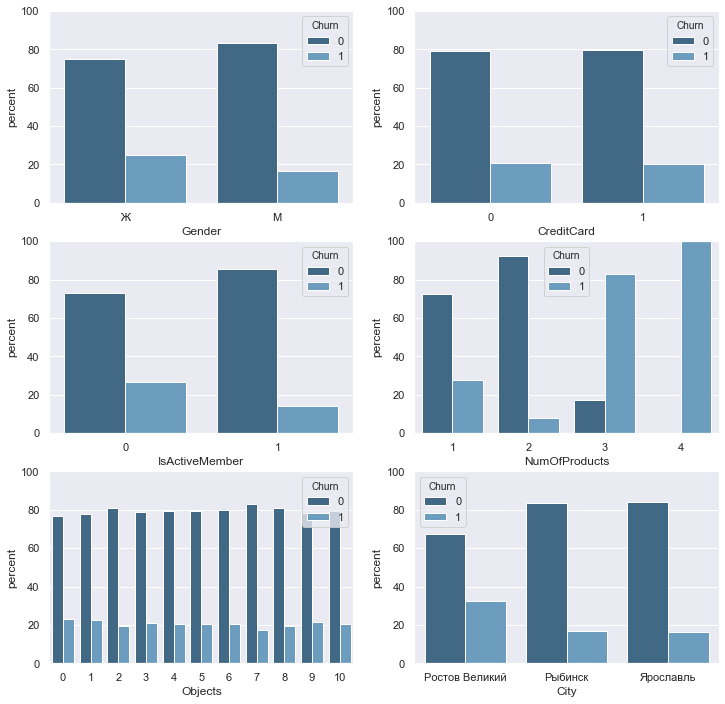

In [24]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, difference):
    percent = (df.groupby(col)['Churn']
                     .value_counts(normalize=True).mul(100)
                     .rename('percent').reset_index())
    sns.catplot(x=col, y='percent', hue='Churn',kind='bar',
              data=percent, palette="Blues_d", ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

In [25]:
# перепроверим разницу в оттоке для NumOfProducts
num_of_products = df.pivot_table(index='Churn', columns = 'NumOfProducts', values = 'userid', aggfunc = 'count')
num_of_products

NumOfProducts,1,2,3,4
Churn,,,,
0,3675.00,4242.00,46.00,nan
1,1409.00,348.00,220.00,60.00


In [26]:
gender = df.pivot_table(index='Churn', columns = 'Gender', values = 'userid', aggfunc = 'count')
gender

Gender,Ж,М
Churn,,
0,3404,4559
1,1139,898


In [27]:
# перепроверим разницу в оттоке для City
city = df.pivot_table(index='Churn', columns = 'City', values = 'userid', aggfunc = 'count')
city

City,Ростов Великий,Рыбинск,Ярославль
Churn,,,
0,1695,2064,4204
1,814,413,810


По результатам этих данных уже можно сделать выводы:
- женщины чаще перестают пользоваться банком, чем мужчины;
- наличие кредитной карточки никак не влияет на отток;
- если клиент отмечен как "активный", он уйдет в меньшей вероятностью;
- все клиенты, пользующиеся 4 продуктами банка, и почти все, пользующиеся 3 - ушли; наименьшая вероятность - у тех, кто пользуется двумя продуктами;
- количество объектов в собственности не влияет на отток;
- клиенты из Ростова Великого покидают банк с большей вероятностью, чем клиенты из других городов - почти треть уходит.

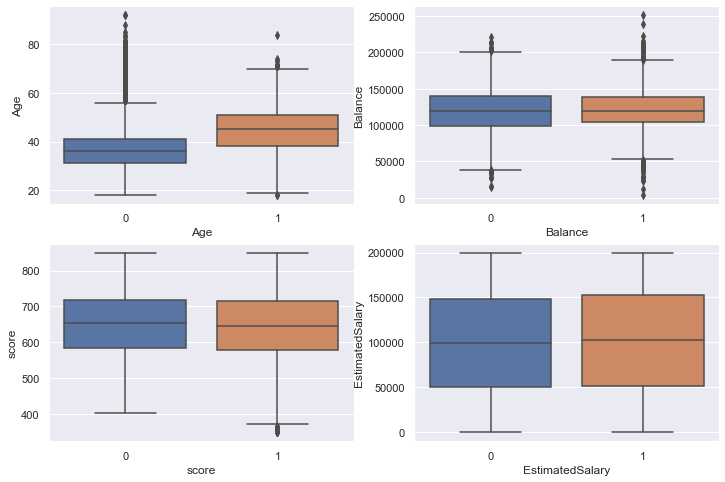

In [28]:
f, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, number_columns):
    sns.boxplot(x = 'Churn', y = col, data=df,ax=ax)
    ax.set(xlabel=col)
plt.show()

In [29]:
df.groupby('Churn').mean()

,userid,score,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary
Churn,,,,,,,,,
0,15733903.88,651.85,37.41,5.03,119535.86,1.54,0.71,0.55,99738.39
1,15732787.96,645.35,44.84,4.93,120746.97,1.48,0.70,0.36,101465.68


Самая значительная разница у уходящих и остоющихся клиентов - разница в возрасте (это была также самая заметная корреляция). 
Показатели баланса `Balance`, оценочной зарплаты `Estimated Salary`, и кредитного скоринга `score`различаются для ушедших и оставшихся клиентов незначительно.

Проверим это с помощью статистических гипотез.

##  4. Проверка статистических гипотез <a name="4"></a>

Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним:

- **H0:** доход тех клиентов, которые пользуются одним продуктом банка, не отличается от дохода тех, которые пользуются двумя;
- **H1:** их доходы отличаются.

In [30]:
# Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

sample_1 = df[df['NumOfProducts']==1]['EstimatedSalary']
sample_2 = df[df['NumOfProducts']==2]['EstimatedSalary']

if len(sample_1)!=len(sample_2):
    print ('Выборки разного размера.')

Выборки разного размера.


In [31]:
# тест для сравнения дисперсий выборок
alpha = 0.05

results = st.bartlett(sample_1,sample_2)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Дисперсии отличаются.")
else:
    print("Дисперсии равные.")

p-value: 0.6063418505980043
Дисперсии равные.


In [32]:
# проверка гипотезы различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

alpha = 0.05

results = st.ttest_ind(sample_1,sample_2, equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


Гипотеза различия дохода между ушедшими и оставшимися клиентами:

- **H0:** доход ушедших клиентов не отличается от дохода оставшихся;
- **H1:** их доходы отличаются.

In [33]:
# Гипотеза различия дохода между ушедшими и оставшимися клиентами

sample_3 = df[df['Churn']==1]['EstimatedSalary']
sample_4 = df[df['Churn']==0]['EstimatedSalary']

if len(sample_1)!=len(sample_2):
    print ('Выборки разного размера.')

Выборки разного размера.


In [34]:
# тест для сравнения дисперсий выборок
alpha = 0.05

results = st.bartlett(sample_3,sample_4)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Дисперсии отличаются.")
else:
    print("Дисперсии равные.")

p-value: 0.6160988342569723
Дисперсии равные.


In [35]:
# проверка 
alpha = 0.05

results = st.ttest_ind(sample_3,sample_4, equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.228924613051458
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевые гипотезы в обоих случаях; нет значимых различий дохода ни между ушедшими и оставшимися клиентами, ни между клиентами, которые пользуются одним или двумя продуктами банка.

##  5. Машинное обучение <a name="5"></a>

- отток клиентов: сравнение работы моделей
- кластеризация клиентов

### Отток клиентов: сравнение работы моделей

Сравнивать будем следующие модели:
- градиентный бустинг
- случайный лес
- логистическую регрессию.

Для градиентного бустинга попробуем подобрать оптимальные параметры `n_estimators` и `max_depth`.

Будем использовать метрики `Precision`, `Recall`, `F1`, `roc_auc` - метрику `accuracy` брать не будем, так как соотношение классов у нас разное. Основной метрикой будем считать `F1`, оптимальные параметры выбирать тоже по ней - она показывает соотношение предыдущих двух метрик. В реальной задаче это стоило бы еще уточнить - если мы хотим точно не упустить никого из уходящих клиентов, например, то нам важнее метрика `Recall`.

Перед тем, как приступить к сравнению, заново сделаем предобработку данных - надо заменить категориальные значения на численные, заполнить пропуски и стандартизировать данные.

In [36]:
# заполним пропуски в балансе нулями, потому что они, скорее всего, и означают ноль
df_ml = df.fillna(0)
df_ml = pd.get_dummies(df_ml)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   userid               10000 non-null  int64  
 1   score                10000 non-null  int64  
 2   Age                  10000 non-null  int64  
 3   Objects              10000 non-null  int64  
 4   Balance              10000 non-null  float64
 5   NumOfProducts        10000 non-null  int64  
 6   CreditCard           10000 non-null  int64  
 7   IsActiveMember       10000 non-null  int64  
 8   EstimatedSalary      10000 non-null  float64
 9   Churn                10000 non-null  int64  
 10  City_Ростов Великий  10000 non-null  uint8  
 11  City_Рыбинск         10000 non-null  uint8  
 12  City_Ярославль       10000 non-null  uint8  
 13  Gender_Ж             10000 non-null  uint8  
 14  Gender_М             10000 non-null  uint8  
dtypes: float64(2), int64(8), uint8(5)
mem

In [37]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_ml.drop(columns = ['Churn'])
y = df_ml['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

In [38]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [39]:
# перебор параметров max_depth и n_estimators для моделей случайного леса и градиентного бустинга

def params_for_model(model):
    test_results = pd.DataFrame(columns=['depth', 'estimators', 
                                     'precision','recall',
                                     'f1_score', 'roc_auc_score'])
    rows_list = []

    for depth in range(2, 19, 2):
        for estim in range(10, 101, 10):
            test_model = model(random_state=1, n_estimators=estim, max_depth=depth)
            test_model.fit(X_train_st, y_train)

            test_pred = test_model.predict(X_test_st)
            test_proba = test_model.predict_proba(X_test_st)[:,1]


            rows_list.append({
                'depth': depth,
                'estimators': estim,
                'precision': precision_score(y_test, test_pred),
                'recall': recall_score(y_test, test_pred),
                'f1_score': f1_score(y_test, test_pred),
                'roc_auc_score': roc_auc_score(y_test, test_proba),
            })
    test_results = pd.DataFrame(rows_list)
    return (test_results)

In [40]:
# оптимальные параметры для градиентного бустинга
test_gb = params_for_model(GradientBoostingClassifier)
test_gb.sort_values(by=['f1_score'], ascending=False).head(5)

,depth,estimators,precision,recall,f1_score,roc_auc_score
23,6,40,0.79,0.48,0.60,0.87
24,6,50,0.78,0.49,0.60,0.87
22,6,30,0.79,0.48,0.60,0.87
28,6,90,0.76,0.49,0.60,0.87
49,10,100,0.75,0.49,0.60,0.85


In [41]:
# оптимальные параметры для случайного леса
test_rf = params_for_model(RandomForestClassifier)
test_rf.sort_values(by=['f1_score'], ascending=False).head(5)

,depth,estimators,precision,recall,f1_score,roc_auc_score
81,18,20,0.79,0.48,0.60,0.84
83,18,40,0.81,0.47,0.59,0.86
82,18,30,0.81,0.46,0.59,0.85
77,16,80,0.83,0.45,0.58,0.86
51,12,20,0.81,0.45,0.58,0.86


Выбирали параметры для наилучшей возможной метрики `F1`. Получилось следующее -`n_estimators = 40` и `max_depth = 6` для градиентного бустинга и `n_estimators = 20` и `max_depth = 18` для случайного леса.

Сравним эти результаты с результатом логистической регрессии.

In [42]:
# функция для выведения метрик
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [43]:
# модель логистической регрессии

lr_model = LogisticRegression(max_iter = 5000)
lr_model.fit(X_train_st, y_train)
y_pred_lr = lr_model.predict(X_test_st)
y_proba_lr = lr_model.predict_proba(X_test_st)[:,1]


print_all_metrics(y_test, y_pred_lr, y_proba_lr,
                  title = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Precision: 0.64
	Recall: 0.22
	F1: 0.33
	ROC_AUC: 0.78


In [44]:
# модель случайного леса

rf_model = RandomForestClassifier(n_estimators = 20, random_state = 1, max_depth = 18)
rf_model.fit(X_train_st, y_train)
y_pred_rf = rf_model.predict(X_test_st)
y_proba_rf = rf_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, y_pred_rf, y_proba_rf, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Precision: 0.79
	Recall: 0.48
	F1: 0.60
	ROC_AUC: 0.84


In [45]:
# модель градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators = 40, random_state = 1, max_depth = 6)
gb_model.fit(X_train_st, y_train)

y_pred_gb = gb_model.predict(X_test_st)
y_proba_gb = gb_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, y_pred_gb, y_proba_gb, 
                  title = 'Метрики для модели градиентного бустинга:')

Метрики для модели градиентного бустинга:
	Precision: 0.79
	Recall: 0.48
	F1: 0.60
	ROC_AUC: 0.87


По итогу можно сказать, что градиентный бустинг показывает лучшие результаты для этой задачи, в дальнейшем можно попробовать перебрать и другие параметры для него.

### Кластеризация клиентов

В прошлом проекте предлагалось проводить кластеризацию без столбца с оттоком пользователей. Интересно, что получится тут, если отток не убирать  - с такими странными данными по зарплате и балансу.

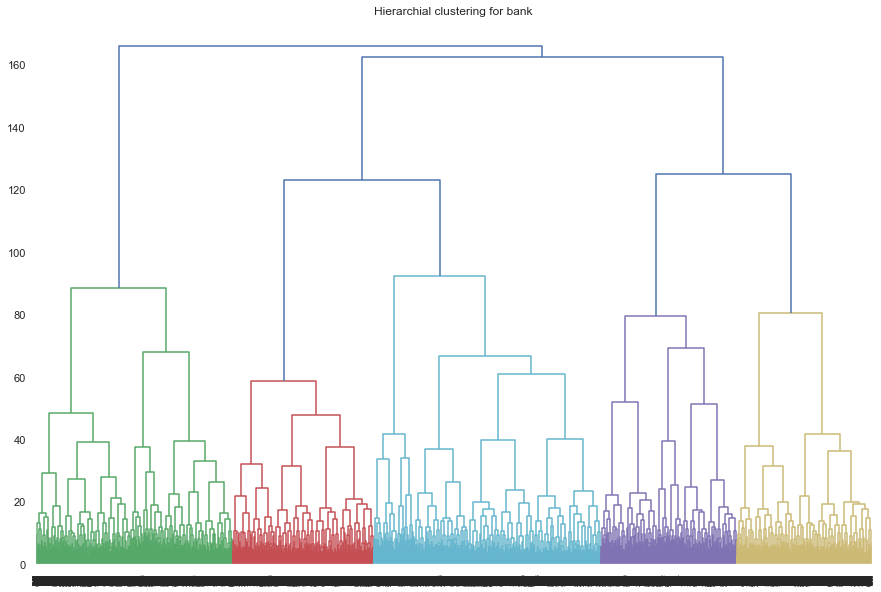

In [46]:
x_sc = scaler.fit_transform(df_ml)

linked = linkage(x_sc, method = 'ward')
# график кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for bank')
plt.show()

In [47]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 1)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

In [48]:
df_ml['cluster'] = labels
# средние значения по кластерам
df_ml.groupby('cluster').mean().T

cluster,0,1,2,3,4
userid,15734462.85,15732029.21,15733291.65,15735038.29,15734804.70
score,651.77,650.06,651.45,649.19,650.99
Age,39.20,38.30,39.77,38.77,38.65
Objects,5.00,5.05,5.01,4.95,5.06
Balance,59862.09,63546.28,119730.12,60322.67,63352.83
NumOfProducts,1.57,1.52,1.52,1.55,1.51
CreditCard,0.71,0.71,0.71,0.70,0.68
IsActiveMember,0.52,0.52,0.50,0.51,0.54
EstimatedSalary,100734.11,100174.25,101113.44,99564.25,98425.69
Churn,0.21,0.13,0.32,0.20,0.13


Как-то это не очень работает. Может быть, надо убрать города и пол, тогда будет лучше, но пока при числе кластеров 3 массив разбивается ровно по городам, при числах 4 и 5 - по городам и полу, делать какие-то выводы по таким данным можно, наверное, но ничего нового относительно уже найденного.

##  5. Выводы <a name="5"></a>

#### Выводы исследовательского анализа данных

1. Данные сомнительного качества:
    - странное распределение оценочной зарплаты `EstimatedSalary`;
    - нет никакой корреляции между балансом `Balance`, кредитным скорингом `score`, оценочной зарплатой `EstimatedSalary`, количеством объектов в собственности `Objects`;
    - нет знания о том, откуда в принципе берется кредитный скоринг, если ни с чем из имеющихся данных он не связан.


2. Распределение клиентов в целом
    - Половина клиентов в выборке - из Ярославля, еще по четверти - из Ростова Великого и Рыбинска;
    - средний возраст клиентов - 37-38 лет;
    - 55% клиентов - мужчины;
    - в среднем на клиента приходится полтора продукта банка, 
    - всего 4% клиентов пользуются более чем двумя продуктами, эти же клиенты - более старшего возраста; 
    - у 71% клиентов есть кредитная карточка;
    - 52% клиентов отмечены как "активные";
    - отток по выборке составляет 20%.

#### Выводы по оттоку пользователей

- самая значительная корреляция оттока пользователей - с возрастом, средний возраст уходящих клиентов - почти 45 лет, тогда как средний возраст остающихся - 37;
- женщины чаще перестают пользоваться банком, чем мужчины;
- если клиент отмечен как "активный", он уйдет в меньшей вероятностью;
- все клиенты, пользующиеся 4 продуктами банка, и почти все, пользующиеся 3 - ушли; наименьшая вероятность - у тех, кто пользуется двумя продуктами;
- клиенты из Ростова Великого покидают банк с большей вероятностью, чем клиенты из других городов - почти треть уходит;
- наличие кредитной карточки никак не влияет на отток, количество объектов в собственности, баланс и оценочная зарплата никак не влияют на отток.

Гипотезы о разнице между доходами для клиентов с одним и двумя продуктами и для ушедших и оставшихся клиентов не подтверждены - доходы не имеют значимых различий.